# Imports

In [2]:
import requests
from zipfile import ZipFile
from io import BytesIO
import fnmatch
import json
from typing import Mapping,List, Dict, Any
from pathlib import Path
from pprint import pprint
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


In [3]:
arcagi_colours = ['#000000',
                  '#1e93ff',
                  '#F93C31',#'#[1,0.2549019607843137,0.21176470588235294,1], # 2 - Red: #F93C31
                  '#4fcc30', # 3 - Green: #2ECC40
                  '#ffdc00', # 4 - Yellow: #FFDC00
                  '#999999', # 5 - Gray:  #AAAAAA
                  '#e53aa3', # 6 - Fuschia: #F012BE
                  '#ff851b', # 7 - Orange: #FF851B
                  '#87d8f1', # 8 - Teal: #7FDBFF;
                  '#921231'] # 9 - Brown: #870C25
arcaci_colormap = ListedColormap(arcagi_colours)


In [4]:
@dataclass
class TaskGridPair:
    input: np.array
    output: np.array

    @classmethod
    def from_dict(cls, d):
        return TaskGridPair(np.asarray(d["input"]),
                          np.asarray(d["output"]))

    def __repr__(self):
        return f"TaskPair[Input: {self.input.shape} -> Output: {self.output.shape}]"

@dataclass
class Task:
    train: List[TaskGridPair]
    test: List[TaskGridPair]

    @classmethod
    def from_dict(cls, d):
        return Task(cls._process_caselist(d["train"]),
                    cls._process_caselist(d["test"]))

    @staticmethod
    def _process_caselist(case_list):
        return [TaskGridPair.from_dict(case_dict) for case_dict in case_list]

    def __repr__(self):
        return f"Task[Training: {len(self.train)} -> Test: {len(self.test)}]"

@dataclass
class TaskSet:
    label: str
    training: Dict[str, Task]
    evaluation: Dict[str, Task]

    @classmethod
    def _glob_to_dict(cls, glob_name, zipfile):
        filelist = fnmatch.filter(zipfile.namelist(), glob_name)
        task_gen = lambda fn: Task.from_dict(json.load(zipfile.open(fn)))
        return {Path(fn).stem: task_gen(fn) for fn in filelist}

    @classmethod
    def from_zipfile(cls, label: str, zipfile: ZipFile):
        return TaskSet(label,
                       cls._glob_to_dict("*/data/training/*.json", zipfile),
                       cls._glob_to_dict("*/data/evaluation/*.json", zipfile))



In [5]:
ARC_LINKS = {'ARC-AGI-1': "https://github.com/fchollet/ARC-AGI/archive/refs/heads/master.zip",
             'ARC-AGI-2': "https://github.com/arcprize/ARC-AGI-2/archive/refs/heads/main.zip"}

def get_zip(link: str) -> ZipFile:
    response = requests.get(link)
    return ZipFile(BytesIO(response.content))

ARC_ZIP = {k: get_zip(v) for k, v in ARC_LINKS.items()}
ARC_DATA = {k:TaskSet.from_zipfile(k,v) for k, v in ARC_ZIP.items()}

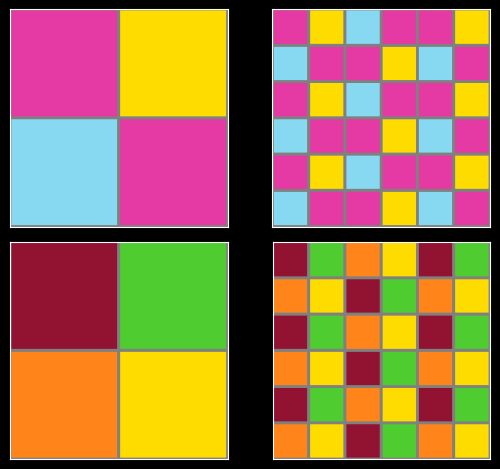

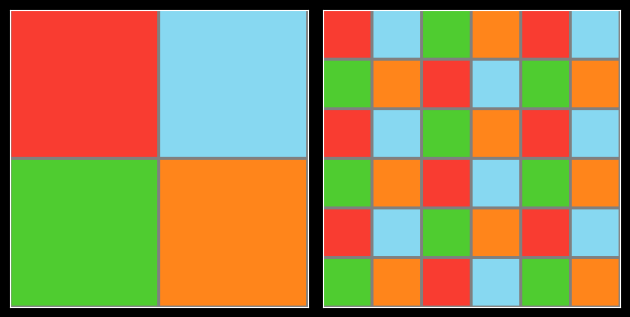

In [28]:
def plotgrid(grid):
    plt.style.use('dark_background')
    plt.pcolor(grid.T,
               edgecolors='grey',
               linewidths=2,
               cmap=arcaci_colormap,
               vmin=0,
               vmax=9)
    plt.gca().set_aspect('equal')
    plt.yticks([])
    plt.xticks([])
    plt.tight_layout()

for k,v in ARC_DATA['ARC-AGI-1'].evaluation.items():
    len_train = len(v.train)
    for i,v2 in enumerate(v.train):
        plt.subplot(len_train,2,i*2+1)
        plotgrid(v2.input)
        plt.subplot(len_train,2,i*2+2)
        plotgrid(v2.output)
    plt.show()
    for v2 in v.test:
        plt.subplot(1,2,1)
        plotgrid(v2.input)
        plt.subplot(1,2,2)
        plotgrid(v2.output)
        plt.show()
    break

